In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_parquet('../OUTPUT/evictions_matched.parquet')

In [6]:
df.shape

(546089, 83)

In [7]:
## Set your desired match confidence here
confidence = 90
df = df.loc[df['match_confidence'] >= confidence]

In [8]:
df.shape

(545594, 83)

In [9]:
# Definitely run this cell!
def normalize_entity(name): # Normalize any fields you want to group by here
    if pd.isna(name):
        return ''
    return name.strip().lower().replace('.', '').replace(',', '')

In [10]:
# Definitely run this cell!
def normalize_columns(df, columns):
    for col in columns:
        df[f'{col}_normalized'] = df[col].apply(normalize_entity)
    return df

In [11]:
# Definitely run this cell!
normalize_fields = ['RA-Name', 'Street1'] #normalize any fields you're using to group here
df = normalize_columns(df, normalize_fields)

Some examples of basic grouping if you want to try yourself.

In [12]:
# This is an example that's used for visualization later on. Run it for some visualizations
ra_groups = df.groupby('RA-Name_normalized').agg({
    'Name': 'count',
    'plaintiff_name': lambda x: list(x),
    'IncorpDate': lambda x: list(x),
    'Zip': lambda x: list(x),
    'filed_date': lambda x: list(x),
    'serial_filing': lambda x: list(x)
}).rename(columns={'Name': 'LLC_Count'}).reset_index()
ra_groups = ra_groups.loc[ra_groups['LLC_Count'] > 1]

In [13]:
# This is an example that's used for visualization later on. Run it for some visualizations
address_groups = df.groupby('Street1_normalized').agg({
    'Name': 'count',
    'plaintiff_name': lambda x: list(x),
    'IncorpDate': lambda x: list(x),
    'Zip': lambda x: list(x),
    'filed_date': lambda x: list(x),
    'serial_filing': lambda x: list(x)
}).rename(columns={'Name': 'LLC_Count'}).reset_index()
address_groups = address_groups.loc[address_groups['LLC_Count'] > 1]

In [14]:
# This is an example that's used for visualization later on. Run it for some visualizations later on.
atty_groups = df.groupby('plaintiff_attorney_normalized').agg({
    'Name':'count',
    'RA-Name': lambda x: list(x),
    'IncorpDate': lambda x: list(x),
    'Zip': lambda x: list(x),
    'filed_date': lambda x: list(x),
    'serial_filing': lambda x: list(x),
    'plaintiff_name': lambda x: list(x)
}).rename(columns={'Name':'LLC_Count'}).reset_index()
atty_groups = atty_groups.loc[atty_groups['LLC_Count'] > 1]

Create some composite keys for analysis. Here's one example, and a function to do it dynamically

In [15]:
# This is just an example. Keep scrolling for dynamic grouping

df['Composite_Key'] =(
    df['RA-Name'].fillna('') + '|' + df['Street1'].fillna('') + '|' + df['plaintiff_attorney_normalized'].fillna('')
)
composite_groups = df.groupby('Composite_Key').agg({
    'Name': 'count',
    'plaintiff_name': lambda x: list(x),
    'IncorpDate': lambda x: list(x),
    'Zip': lambda x: list(x),
    'filed_date': lambda x: list(x),
    'serial_filing': lambda x: list(x)
}).rename(columns={'Name': 'LLC_Count'}).reset_index()
composite_groups = composite_groups.loc[composite_groups['LLC_Count'] > 1]

In [16]:
# Definitely run this cell!
def create_composite_key(df, columns, key_name='Composite_Key'):
    df[key_name] = df[columns].fillna('').agg('|'.join, axis=1)
    return df, key_name

In [17]:
# Definitely run this cell!
df['IncorpDate'] = pd.to_datetime(df['IncorpDate'], errors='coerce')
df['filed_date'] = pd.to_datetime(df['filed_date'], errors='coerce')

In [18]:
# Definitely run this cell!

def analyze_llc_networks(df, composite_key):
    """
    Identify and analyze networks of created composite group.
    
    Parameters:
    - df (pd.DataFrame): Input DataFrame containing the composite key column.
    - composite_key (str): Name of the composite key column to group by (e.g., 'Composite_Key').
    
    Returns:
    - tuple: (all_groups, large_groups) where all_groups is the full analysis and large_groups is the top 20 networks.
    """
    if composite_key not in df.columns:
        raise ValueError(f"Composite key column '{composite_key}' not found in DataFrame")
    
    df = df.set_index(composite_key)

    # Group by the provided composite key
    groups = df.groupby(level=0).agg({
        'Name': 'count',
        'RA-Name': list,
        'plaintiff_name': list,
        'plaintiff_attorney': list,
        'IncorpDate': list,
        'Zip': list,
        'filed_date': list,
        'serial_filing': list
    }).rename(columns={'Name': 'LLC_Count'}).reset_index()

    # Filter for groups with more than one LLC
    groups = groups.loc[groups['LLC_Count'] > 1]

    # Enrich with timespan and serial filer stats
    def parse_dates(dates):
        return [d for d in dates if pd.notna(d)]

    groups['Timespan_Days'] = groups['IncorpDate'].apply(
        lambda dates: (max(dates) - min(dates)).days if len(dates) > 1 else 0
    )

    groups['Filing_Timespan_Days'] = groups['filed_date'].apply(
        lambda dates: (max(dates) - min(dates)).days if len(dates) > 1 else 0
    )

    groups['Serial_Filer_Count'] = groups['serial_filing'].apply(
        lambda x: sum(filing is True for filing in x)
    )

    groups['Serial_Filer_Pct'] = groups['Serial_Filer_Count'] / groups['LLC_Count']

    # Sort for biggest networks and get top 20
    large_groups = groups.sort_values('LLC_Count', ascending=False).head(20)

    return groups, large_groups

# Dynamic grouping!
Instructions:
1. Make sure all fields are normalized. See above to normalize fields (creates new column name that looks like:
'column_name' + '_normalized')
2. Include any fields you want to group by in the fields list, separated by commas. This example groups by registered agent, principal address, and plaintiff attorney.
3. Run the next cells!

In [19]:
# Definitely run this cell!
# Dynamic analysis! See example usage 
fields = ['RA-Name_normalized', 'Street1_normalized', 'plaintiff_attorney_normalized']
df, composite_key = create_composite_key(df, fields)

In [20]:
# Definitely run this cell!

groups, large_groups = analyze_llc_networks(df, composite_key)

In [21]:
# Definitely run this cell!

print("=== Summary Statistics ===")
key_metrics = ['LLC_Count', 'Timespan_Days', 'Filing_Timespan_Days', 'Serial_Filer_Pct']
print(groups[key_metrics].describe())

=== Summary Statistics ===
          LLC_Count  Timespan_Days  Filing_Timespan_Days  Serial_Filer_Pct
count  16112.000000   16112.000000          16112.000000      16112.000000
mean      33.085713     102.711457            591.572493          0.273014
std      128.555595     601.166224            678.539933          0.268150
min        2.000000       0.000000              0.000000          0.000000
25%        3.000000       0.000000             31.000000          0.000000
50%        6.000000       0.000000            306.000000          0.250000
75%       19.000000       0.000000            982.000000          0.500000
max     5076.000000    9340.000000           2246.000000          1.000000


In [22]:
# Definitely run this cell!

print("\nTotal number of composite groups:", len(groups))
print("Number of groups with serial filers:", len(groups[groups['Serial_Filer_Count'] > 0]))
print("Top 5 largest groups by LLC count:")
print(groups[[composite_key, 'LLC_Count']].sort_values('LLC_Count', ascending=False).head())


Total number of composite groups: 16112
Number of groups with serial filers: 10442
Top 5 largest groups by LLC count:
                                           Composite_Key  LLC_Count
28176                |6031 connection dr ste 200|solodar       5076
27481      zenbusiness inc|2332 antiqua ct|dankos gordon       4221
28179        |6031 connection dr ste 200|solodar solodar       3692
25523  united states corporation agents  inc|4 redbud...       2713
1755   bernard g  meyer jr|2101 ermavedo drive|offit ...       2319


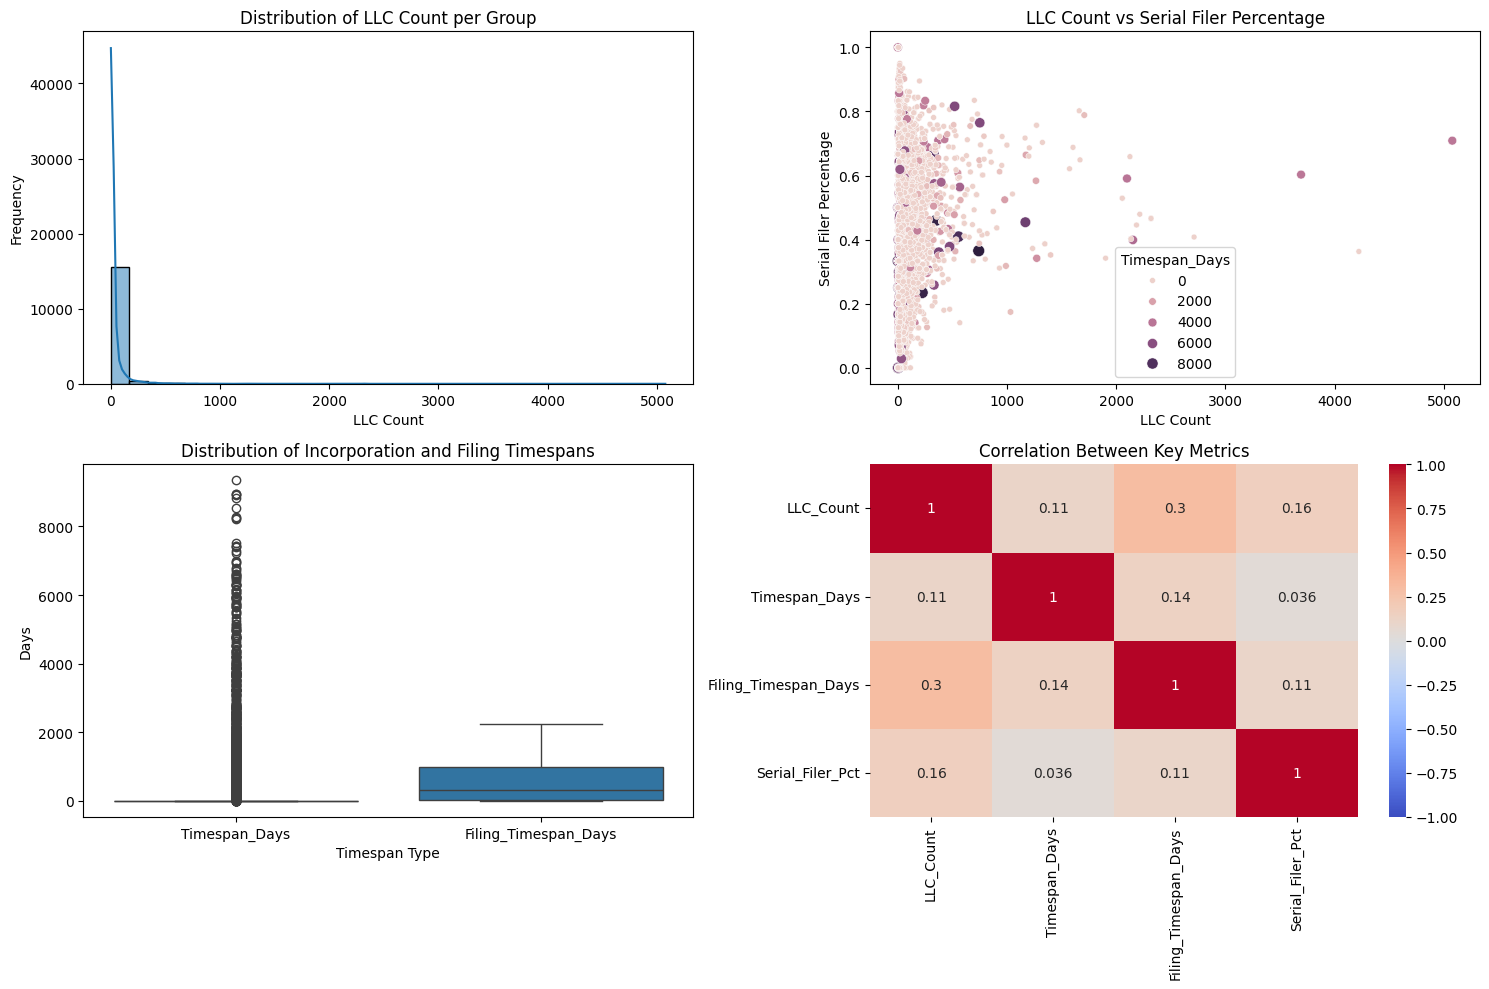

In [23]:
# Definitely run this cell!

plt.figure(figsize=(15, 10))

# 2.1 Histogram of LLC Count
plt.subplot(2, 2, 1)
sns.histplot(groups['LLC_Count'], bins=30, kde=True)
plt.title('Distribution of LLC Count per Group')
plt.xlabel('LLC Count')
plt.ylabel('Frequency')

# 2.2 Scatter plot: LLC Count vs Serial Filer Percentage
plt.subplot(2, 2, 2)
sns.scatterplot(data=groups, x='LLC_Count', y='Serial_Filer_Pct', size='Timespan_Days', hue='Timespan_Days')
plt.title('LLC Count vs Serial Filer Percentage')
plt.xlabel('LLC Count')
plt.ylabel('Serial Filer Percentage')

# 2.3 Box plot of Timespan Days
plt.subplot(2, 2, 3)
sns.boxplot(data=groups[['Timespan_Days', 'Filing_Timespan_Days']].melt(), x='variable', y='value')
plt.title('Distribution of Incorporation and Filing Timespans')
plt.xlabel('Timespan Type')
plt.ylabel('Days')

# 2.4 Correlation heatmap
plt.subplot(2, 2, 4)
corr = groups[key_metrics].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Key Metrics')

plt.tight_layout()
plt.show()
plt.savefig('../OUTPUT/composite_groups_eda.png')
plt.close()

In [24]:
# 3. Key Insights
print("\n=== Key Insights ===")
# Largest networks
largest_network = groups.loc[groups['LLC_Count'].idxmax()]
print(f"Largest network ({largest_network[composite_key]}) has {largest_network['LLC_Count']} LLCs.")

# Serial filer prevalence
high_serial_groups = groups[groups['Serial_Filer_Pct'] > 0.5]
print(f"Number of groups with >50% serial filers: {len(high_serial_groups)}")

# Temporal patterns
long_timespan = groups[groups['Timespan_Days'] > groups['Timespan_Days'].quantile(0.75)]
print(f"Number of groups with incorporation timespan above 75th percentile: {len(long_timespan)}")

# Example of a group with high serial filing
if not high_serial_groups.empty:
    example_group = high_serial_groups.iloc[0]
    print("\nExample group with high serial filing:")
    print(f"- Composite Key: {example_group[composite_key]}")
    print(f"- LLC Count: {example_group['LLC_Count']}")
    print(f"- Serial Filer Percentage: {example_group['Serial_Filer_Pct']:.2%}")
    print(f"- Registered Agents: {example_group['RA-Name'][:5]}")  # Show first 5 for brevity


=== Key Insights ===
Largest network (|6031 connection dr ste 200|solodar) has 5076 LLCs.
Number of groups with >50% serial filers: 2828
Number of groups with incorporation timespan above 75th percentile: 1032

Example group with high serial filing:
- Composite Key: 7820 whitepine  llc|6501 goldleaf dr|selfrepresented
- LLC Count: 3
- Serial Filer Percentage: 66.67%
- Registered Agents: ['7820 Whitepine  LLC', '7820 Whitepine  LLC', '7820 Whitepine  LLC']


#### Everything past this point is work-in-progress. There's some good stuff but it's definitely not done.

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import networkx as nx
# import plotly.express as px
# import numpy as np
# from sklearn.ensemble import IsolationForest
# from collections import Counter
# import re

# def advanced_eda_composite_groups(groups, composite_key='Composite_Key'):
#     """
#     Perform advanced exploratory data analysis on composite groups from analyze_llc_networks.
    
#     Parameters:
#     - groups (pd.DataFrame): DataFrame containing grouped LLC network data.
#     - composite_key (str): Name of the composite key column (default: 'Composite_Key').
    
#     Returns:
#     - None: Outputs analyses, visualizations, and insights to console and files.
#     """
#     # Set plot style
#     sns.set(style="whitegrid")
    
#     # 1. Network Analysis: Build and Analyze LLC Network Graph
#     print("=== Network Analysis ===")
#     G = nx.Graph()
#     for _, row in groups.iterrows():
#         group_id = row[composite_key]
#         ra_names = row['RA-Name']
#         for ra in set(ra_names):  # Connect groups sharing registered agents
#             G.add_node(group_id, llc_count=row['LLC_Count'], type='group')
#             G.add_node(ra, type='ra')
#             G.add_edge(group_id, ra, weight=1)
    
#     # Compute network metrics
#     degree_centrality = nx.degree_centrality(G)
#     clustering_coeff = nx.clustering(G)
#     largest_cc = max(nx.connected_components(G), key=len)
#     largest_cc_subgraph = G.subgraph(largest_cc)
    
#     print(f"Number of nodes: {G.number_of_nodes()}")
#     print(f"Number of edges: {G.number_of_edges()}")
#     print(f"Size of largest connected component: {len(largest_cc)}")
#     print(f"Average clustering coefficient: {np.mean(list(clustering_coeff.values())):.3f}")
    
#     # Visualize network (largest component, simplified for clarity)
#     plt.figure(figsize=(10, 8))
#     pos = nx.spring_layout(largest_cc_subgraph)
#     nx.draw(largest_cc_subgraph, pos, node_size=50, node_color='lightblue', 
#             with_labels=False, alpha=0.7)
#     plt.title('Largest Connected Component of LLC Network')
#     plt.savefig('llc_network.png')
#     plt.close()
    
#     # 2. Temporal Analysis: Incorporation and Filing Trends
#     print("\n=== Temporal Analysis ===")
#     groups['IncorpDate_First'] = groups['IncorpDate_Parsed'].apply(
#         lambda x: min(x) if x else pd.NaT
#     )
#     groups['IncorpYear'] = groups['IncorpDate_First'].dt.year
#     groups['FilingYear'] = groups['FilingDate_Parsed'].apply(
#         lambda x: min(x).year if x else np.nan
#     )
    
#     # Plot incorporation and filing trends
#     plt.figure(figsize=(12, 6))
#     sns.histplot(groups['IncorpYear'].dropna(), bins=20, color='blue', alpha=0.5, label='Incorporation')
#     sns.histplot(groups['FilingYear'].dropna(), bins=20, color='red', alpha=0.5, label='Filing')
#     plt.title('Distribution of Incorporation and Filing Years')
#     plt.xlabel('Year')
#     plt.ylabel('Number of Groups')
#     plt.legend()
#     plt.savefig('temporal_trends.png')
#     plt.close()
    
#     # Time lag between incorporation and filing
#     groups['Incorp_to_Filing_Days'] = groups.apply(
#         lambda row: (min(row['FilingDate_Parsed']) - min(row['IncorpDate_Parsed'])).days 
#         if row['FilingDate_Parsed'] and row['IncorpDate_Parsed'] else np.nan, axis=1
#     )
#     print(f"Average time from incorporation to first filing: {groups['Incorp_to_Filing_Days'].mean():.1f} days")
    
#     # 3. Geographic Analysis: Zip Code Patterns
#     print("\n=== Geographic Analysis ===")
#     groups['Primary_Zip'] = groups['Zip'].apply(lambda x: Counter(x).most_common(1)[0][0] if x else None)
#     zip_counts = groups['Primary_Zip'].value_counts()
#     print(f"Top 5 Zip codes by group count:\n{zip_counts.head()}")
    
#     # Interactive choropleth map (assuming Zip codes are US-based)
#     zip_df = zip_counts.reset_index()
#     zip_df.columns = ['Zip', 'Group_Count']
#     zip_df['Zip'] = zip_df['Zip'].astype(str).str.zfill(5)
#     fig = px.choropleth(zip_df, 
#                         locations='Zip', 
#                         locationmode='USA-states', 
#                         color='Group_Count', 
#                         scope='usa', 
#                         title='Geographic Distribution of LLC Groups by Zip Code',
#                         color_continuous_scale='Viridis')
#     fig.write_html('zip_map.html')
    
#     # 4. Entity Overlap Analysis
#     print("\n=== Entity Overlap Analysis ===")
#     # Count unique plaintiffs and attorneys per group
#     groups['Unique_Plaintiffs'] = groups['plaintiff_name'].apply(lambda x: len(set(x)))
#     groups['Unique_Attorneys'] = groups['plaintiff_attorney'].apply(lambda x: len(set(x)))
    
#     # Plot overlap vs. LLC count
#     plt.figure(figsize=(10, 6))
#     sns.scatterplot(data=groups, x='LLC_Count', y='Unique_Plaintiffs', size='Unique_Attorneys', 
#                     hue='Serial_Filer_Pct', palette='coolwarm')
#     plt.title('LLC Count vs. Unique Plaintiffs, Sized by Unique Attorneys')
#     plt.xlabel('LLC Count')
#     plt.ylabel('Unique Plaintiffs')
#     plt.savefig('entity_overlap.png')
#     plt.close()
    
#     # Most common plaintiffs across groups
#     all_plaintiffs = [p for sublist in groups['plaintiff_name'] for p in sublist]
#     plaintiff_counts = Counter(all_plaintiffs)
#     print(f"Top 5 plaintiffs by appearance:\n{pd.Series(plaintiff_counts).nlargest(5)}")
    
#     # 5. Naming Pattern Analysis
#     print("\n=== Naming Pattern Analysis ===")
#     def extract_name_patterns(names):
#         patterns = []
#         for name in names:
#             # Extract numeric suffixes (e.g., LLC 1, LLC 2) or common words
#             numeric = re.search(r'\d+$', name)
#             if numeric:
#                 patterns.append('Numeric Suffix')
#             elif 'LLC' in name.upper():
#                 patterns.append('Contains LLC')
#         return Counter(patterns).most_common(1)[0][0] if patterns else 'Other'
    
#     groups['Name_Pattern'] = groups['Name'].apply(extract_name_patterns)
#     pattern_counts = groups['Name_Pattern'].value_counts()
#     print(f"Most common naming patterns:\n{pattern_counts}")
    
#     # 6. Anomaly Detection
#     print("\n=== Anomaly Detection ===")
#     features = ['LLC_Count', 'Timespan_Days', 'Filing_Timespan_Days', 'Serial_Filer_Pct', 
#                 'Unique_Plaintiffs', 'Unique_Attorneys']
#     X = groups[features].fillna(0)
#     iso_forest = IsolationForest(contamination=0.05, random_state=42)
#     groups['Anomaly'] = iso_forest.fit_predict(X)
    
#     anomalies = groups[groups['Anomaly'] == -1]
#     print(f"Number of anomalous groups: {len(anomalies)}")
#     print("Top 5 anomalous groups:")
#     print(anomalies[[composite_key, 'LLC_Count', 'Serial_Filer_Pct', 'Unique_Plaintiffs']].head())
    
#     # Plot anomalies
#     plt.figure(figsize=(10, 6))
#     sns.scatterplot(data=groups, x='LLC_Count', y='Serial_Filer_Pct', 
#                     hue='Anomaly', palette={1: 'blue', -1: 'red'})
#     plt.title('Anomalous Groups (Red) vs. Normal Groups (Blue)')
#     plt.xlabel('LLC Count')
#     plt.ylabel('Serial Filer Percentage')
#     plt.savefig('anomalies.png')
#     plt.close()

# advanced_eda_composite_groups(groups, composite_key='Composite_Key')

: 

: 

: 

Other stuff specific to registered agents, addresses, and attorneys

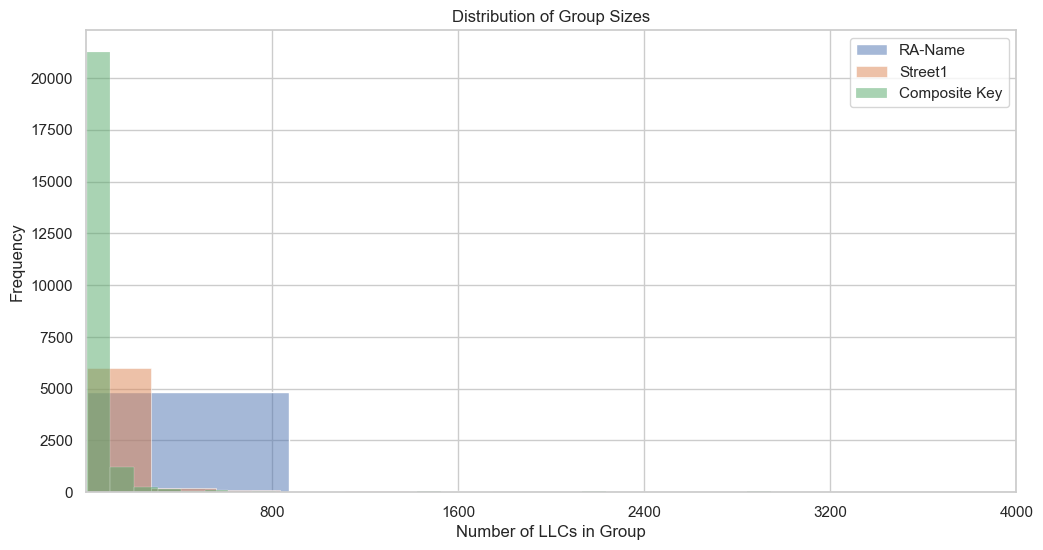

: 

: 

: 

In [ ]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(12, 6))
sns.histplot(ra_groups['LLC_Count'], bins=50, label='RA-Name', alpha=0.5)
sns.histplot(address_groups['LLC_Count'], bins=50, label='Street1', alpha=0.5)
sns.histplot(composite_groups['LLC_Count'], bins=50, label='Composite Key', alpha=0.5)

plt.xlabel('Number of LLCs in Group')
plt.ylabel('Frequency')
plt.title('Distribution of Group Sizes')
plt.legend()

plt.xlim(0, 4000) 
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=5))  # Limit to max 5 ticks

plt.savefig('../OUTPUT/group_size_distribution.png')
plt.show()
plt.close()

Most popular group with these 3 fields is no registered agent at that address represented by solodar (looks to be a law firm in richmond)

In [ ]:
# ra_entities = df.merge(ra_groups[['RA-Name']], on='RA-Name', how='inner')[['Name', 'RA-Name', 'plaintiff_name']]
# address_entities = df.merge(address_groups[['Street1']], on='Street1', how='inner')[['Name', 'Street1', 'plaintiff_name']]

# overlap = pd.merge(
#     ra_entities,
#     address_entities,
#     on='Name',
#     how='inner',
#     suffixes=('_ra', '_addr')
# )
# print("\nNumber of overlapping LLCs (RA-Name and Street1):", len(overlap))
# print("Sample overlapping LLCs (first 5):")
# print(overlap[['Name', 'RA-Name', 'Street1', 'plaintiff_name_ra']].head(5))

: 

: 

: 

Some quick statistics

In [ ]:
print("\n=== Composite Key Group Statistics ===")
print(f"Number of combinations with multiple LLCs: {len(composite_groups)}")
print(f"Largest composite network has {composite_groups['LLC_Count'].max()} LLCs")
print(f"Average LLCs per composite key: {composite_groups['LLC_Count'].mean():.2f}")
print(f"Median LLCs per composite key: {composite_groups['LLC_Count'].median():.2f}")
print(f"Total LLCs in composite networks: {composite_groups['LLC_Count'].sum()}")



=== Composite Key Group Statistics ===
Number of combinations with multiple LLCs: 23294
Largest composite network has 5076 LLCs
Average LLCs per composite key: 46.12
Median LLCs per composite key: 6.00
Total LLCs in composite networks: 1074259


: 

: 

: 

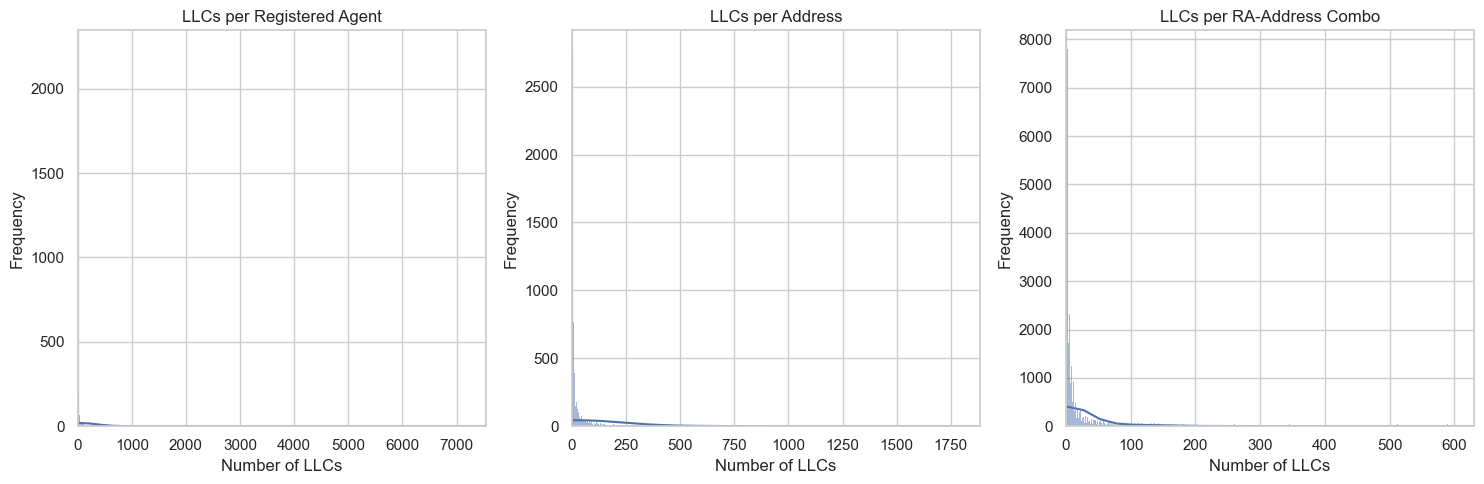

: 

: 

: 

In [ ]:
ra_xlim = ra_groups['LLC_Count'].quantile(0.99)
address_xlim = address_groups['LLC_Count'].quantile(0.99)
composite_xlim = composite_groups['LLC_Count'].quantile(0.99)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(ra_groups['LLC_Count'], kde=True)
plt.title('LLCs per Registered Agent')
plt.xlabel('Number of LLCs')
plt.ylabel('Frequency')
plt.xlim(0, ra_xlim)

plt.subplot(1, 3, 2)
sns.histplot(address_groups['LLC_Count'], kde=True)
plt.title('LLCs per Address')
plt.xlabel('Number of LLCs')
plt.ylabel('Frequency')
plt.xlim(0, address_xlim)

plt.subplot(1, 3, 3)
sns.histplot(composite_groups['LLC_Count'], kde=True)
plt.title('LLCs per RA-Address Combo')
plt.xlabel('Number of LLCs')
plt.ylabel('Frequency')
plt.xlim(0, composite_xlim)

plt.tight_layout()
plt.savefig('../OUTPUT/network_size_distributions.png')
plt.show()
plt.close()


=== LLC Network Size Statistics ===
Total networks identified: 23294
Average LLCs per network: 46.12
Median LLCs per network: 6.0
Largest network size: 5076.0


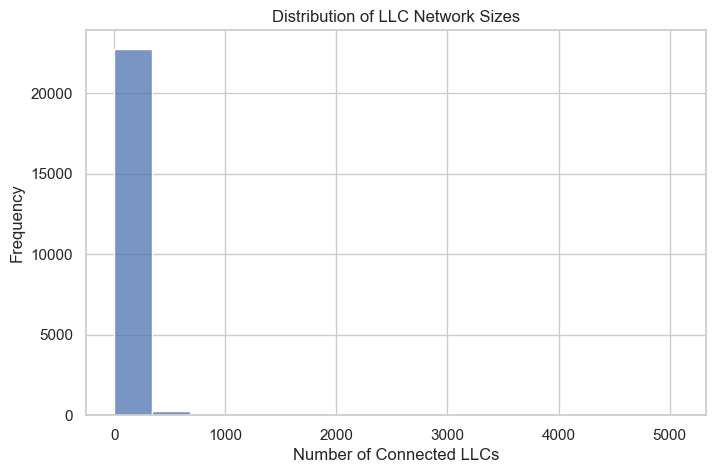

: 

: 

: 

In [ ]:
network_size_stats = composite_groups['LLC_Count'].describe()
print("=== LLC Network Size Statistics ===")
print(f"Total networks identified: {len(composite_groups)}")
print(f"Average LLCs per network: {network_size_stats['mean']:.2f}")
print(f"Median LLCs per network: {network_size_stats['50%']:.1f}")
print(f"Largest network size: {network_size_stats['max']}")

plt.figure(figsize=(8, 5))
sns.histplot(composite_groups['LLC_Count'], bins=15)
plt.title('Distribution of LLC Network Sizes')
plt.xlabel('Number of Connected LLCs')
plt.ylabel('Frequency')
plt.savefig('../OUTPUT/network_sizes.png')

In [ ]:
print("\n=== LLC Formation Timeline Analysis ===")
formation_stats = composite_groups['Timespan_Days'].describe()
print(f"Average timespan of LLC formations within networks: {formation_stats['mean']:.1f} days")
print(f"Median formation timespan: {formation_stats['50%']:.1f} days")

# Count networks with rapid LLC formation (within 30 days)
rapid_formation = composite_groups[composite_groups['Timespan_Days'] <= 30]
print(f"Networks with rapid LLC formation (≤30 days): {len(rapid_formation)} ({len(rapid_formation)/len(composite_groups):.1%})")

plt.figure(figsize=(10, 6))
plt.scatter(composite_groups['LLC_Count'], composite_groups['Timespan_Days'], alpha=0.6)
plt.title('Network Size vs. LLC Formation Timespan')
plt.xlabel('Number of LLCs in Network')
plt.ylabel('Days Between First and Last LLC Formation')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('../OUTPUT/formation_timespan_scatter.png')


=== LLC Formation Timeline Analysis ===


KeyError: 'Timespan_Days'

: 

: 

: 


=== Serial Filing Analysis ===
Average serial filer percentage within networks: 20.9%
Networks with 100% serial filers: 62
Networks with >75% serial filers: 139


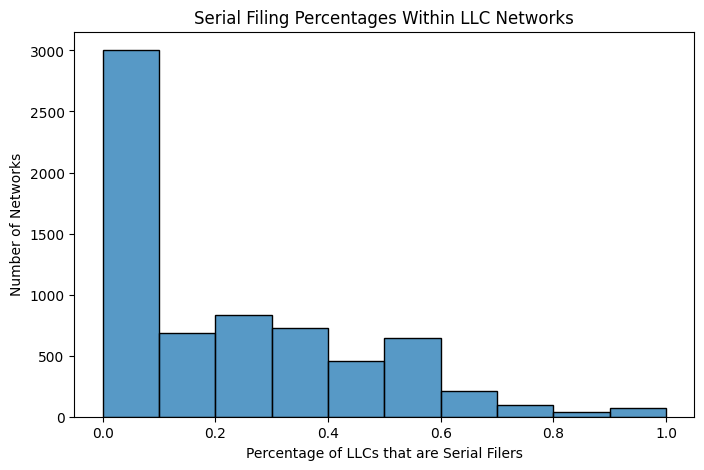

: 

: 

: 

In [ ]:
# Analysis of serial filing within networks
print("\n=== Serial Filing Analysis ===")
print(f"Average serial filer percentage within networks: {composite_groups['Serial_Filer_Pct'].mean():.1%}")
print(f"Networks with 100% serial filers: {len(composite_groups[composite_groups['Serial_Filer_Pct'] == 1])}")
print(f"Networks with >75% serial filers: {len(composite_groups[composite_groups['Serial_Filer_Pct'] > 0.75])}")

# Quick histogram of serial filing percentages
plt.figure(figsize=(8, 5))
sns.histplot(composite_groups['Serial_Filer_Pct'], bins=10)
plt.title('Serial Filing Percentages Within LLC Networks')
plt.xlabel('Percentage of LLCs that are Serial Filers')
plt.ylabel('Number of Networks')
plt.savefig('../OUTPUT/serial_filing_hist.png')

In [ ]:
# Analyze filing timespans - how long networks are active in filings
print("\n=== Eviction Filing Timeline Analysis ===")
filing_stats = composite_groups['Filing_Timespan_Days'].describe()
print(f"Average active filing period: {filing_stats['mean']:.1f} days")
print(f"Median active filing period: {filing_stats['50%']:.1f} days")
print(f"Longest active filing period: {filing_stats['max']:.1f} days")

# Calculate filing density (filings per day)
composite_groups['Filing_Density'] = composite_groups['LLC_Count'] / (composite_groups['Filing_Timespan_Days'] + 1)  # +1 to avoid division by zero
print(f"Average filing density: {composite_groups['Filing_Density'].mean():.2f} filings per day")
print(f"Maximum filing density: {composite_groups['Filing_Density'].max():.2f} filings per day")


=== Eviction Filing Timeline Analysis ===
Average active filing period: 1073.4 days
Median active filing period: 1021.0 days
Longest active filing period: 2186.0 days
Average filing density: 0.20 filings per day
Maximum filing density: 23.00 filings per day


: 

: 

: 

In [ ]:
# Examine the largest networks in detail
print("\n=== Top 5 Largest LLC Networks ===")
for idx, row in large_networks.head(5).iterrows():
    ra, addr = row['Composite_Key'].split('|')
    print(f"\nNetwork #{idx+1}: {row['LLC_Count']} LLCs")
    print(f"RA: {ra}, Address: {addr}")
    print(f"LLCs formed over {row['Timespan_Days']} days")
    print(f"Active filing period: {row['Filing_Timespan_Days']} days")
    print(f"Serial filer percentage: {row['Serial_Filer_Pct']:.1%}")
    print(f"Sample LLCs: {', '.join(row['plaintiff_name'][:3])}")


=== Top 5 Largest LLC Networks ===

Network #364: 12839 LLCs
RA: ARVIND B   AMIN, Address: 208 GOLDEN MAPLE DR
LLCs formed over 0 days
Active filing period: 2179 days
Serial filer percentage: 55.8%
Sample LLCs: 319 WINSTON ASSOCIATES LLC SUCC IN INT TO, 319 WINSTON ASSOCIATES LLC SUCC IN INT TO, 319 WINSTON ASSOCIATES LLC SUCC IN INT TO

Network #3993: 11586 LLCs
RA: HORACE   JONES, Address: 1555 KING ST STE 200
LLCs formed over 0 days
Active filing period: 2179 days
Serial filer percentage: 50.9%
Sample LLCs: 1 SQ APTS LP, 1 SQ APTS LP, 1 SQ APTS LP

Network #9381: 7786 LLCs
RA: THAO NHU   DINH, Address: 7704-C RICHMOND HWY
LLCs formed over 0 days
Active filing period: 2184 days
Serial filer percentage: 34.8%
Sample LLCs: ARUNDINA LLC, COG AND JOB HOLDINGS LLC, JK PROPERTY HOLDINGS LP

Network #4114: 5077 LLCs
RA: ICAFS  INC., Address: 2922 Hathaway Road
LLCs formed over 1968 days
Active filing period: 2158 days
Serial filer percentage: 64.4%
Sample LLCs: CHVA LLC, CHVA LLC, CHVA LLC

: 

: 

: 


=== Formation to Filing Timeline Analysis ===
Average days from network formation to first filing: 2338.4
Networks filing evictions within 30 days of formation: 967


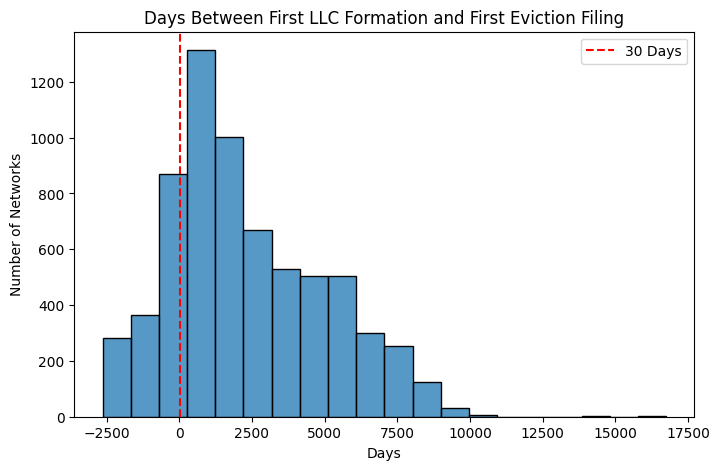

: 

: 

: 

In [ ]:
# Calculate time between LLC formation and first filing
composite_groups['Avg_Days_To_First_Filing'] = composite_groups.apply(
    lambda row: (min(row['FilingDate_Parsed']) - min(row['IncorpDate_Parsed'])).days 
    if len(row['FilingDate_Parsed']) > 0 and len(row['IncorpDate_Parsed']) > 0 
    else np.nan, axis=1
)

print("\n=== Formation to Filing Timeline Analysis ===")
print(f"Average days from network formation to first filing: {composite_groups['Avg_Days_To_First_Filing'].mean():.1f}")
print(f"Networks filing evictions within 30 days of formation: {len(composite_groups[composite_groups['Avg_Days_To_First_Filing'] <= 30])}")

# Quick histogram
plt.figure(figsize=(8, 5))
sns.histplot(composite_groups['Avg_Days_To_First_Filing'].dropna(), bins=20)
plt.title('Days Between First LLC Formation and First Eviction Filing')
plt.xlabel('Days')
plt.ylabel('Number of Networks')
plt.axvline(x=30, color='r', linestyle='--', label='30 Days')
plt.legend()
plt.savefig('../OUTPUT/formation_to_filing_hist.png')